In [3]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import pandas as pd
from scipy.interpolate import interp2d

In [4]:
#Definitions

#2d Gauss
def gauss2d(data, amplitude, x0, sigmax, y0, sigmay, offset):
    return amplitude * np.exp(-((data[:, :, 0] - x0)**2 / (2 * sigmax**2) + (data[:, :, 1] - y0)**2 / (2 * sigmay**2))) + offset

# Flatten the output of gauss2d
def gauss2d_flatten(*args, **kwargs):
    return gauss2d(*args, **kwargs).flatten()

#2D Gauss
def gauss(x, amplitude, x0, sigma, offset):
    return amplitude * np.exp(-(x - x0)**2 / (2 * sigma**2)) + offset


def fit(scan):    
    # Normalize data to unity
    scan /= np.max(scan)
    
    # Camera settings
    pixsize = 5.0  # pixel size in um

    X, Y = scan.shape  # actual image size

    # Creating meshgrid
    XX, YY = np.meshgrid(np.arange(1, Y + 1), np.arange(1, X + 1))
    xdata = np.stack([XX, YY], axis=-1)

    # Fitting subroutine
    # Parameters: [Amplitude, x0, sigmax, y0, sigmay, offset]
    c0 = [1, X / 2, X / 4, Y / 2, Y / 4, 0.1]  # Initial guess parameters

    lb = [0, 0, 0, 0, 0, 0]  # Lower bound
    ub = [1, X, X, Y, Y, 1]  # Upper bound

    c, _ = curve_fit(gauss2d_flatten, xdata, scan.flatten(), p0=c0, bounds=(lb, ub))

    x_max_index = int(np.floor(c[1]))
    y_max_index = int(np.floor(c[3]))

    # Calculate cross sections
    xvh = np.arange(1, Y + 1)
    yvh = xvh * 0 + y_max_index
    hPoints = np.interp(xvh, XX[0, :], scan[y_max_index, :])

    yvv = np.arange(1, X + 1)
    xvv = yvv * 0 + y_max_index 
    vPoints = np.interp(yvv, YY[:, 0], scan[:, x_max_index])


    # Cross section refit
    c0h = [1, c[1], c[2], c[5]]  # Inital guess parameters
    c0v = [1, c[3], c[4], c[5]]

    lb = [0, 0, 0, 0]  # Lower bound
    ub = [1, Y, Y, 1]  # Upper bound

    ch, _ = curve_fit(gauss, xvh, hPoints, p0=c0h, bounds=(lb, ub))
    cv, _ = curve_fit(gauss, yvv, vPoints, p0=c0v, bounds=(lb, ub))

    data_fitted = gauss2d(xdata, *c)

    # Plot profiles
    fig, axs = plt.subplots(2, 2, figsize=(10, 8))

    axs[1, 0].imshow(scan, extent=[XX.min(), XX.max(), YY.min(), YY.max()], origin='lower', cmap='jet')
    #axs[1, 0].plot(np.arange(350,550),[200]*len(np.arange(350,550)),color = 'red')
    #axs[1, 0].plot([350]*len(np.arange(200,425)),np.arange(200,425),color = 'red')
    axs[1, 0].contour(XX,YY, data_fitted.reshape(scan.shape[0], scan.shape[1]), 8, colors='w',alpha=.5)
    axs[1, 0].set_title('2D Gaussian Fit')
    axs[0, 0].plot(xvh, hPoints, 'r.', label='Data')
    axs[0, 0].plot(xvh, gauss(xvh, *ch), 'k--', label='1D Fit')
    axs[0, 0].legend()
    axs[0, 0].set_title('X Cross Section')

    axs[1, 1].plot(vPoints, yvv,  'g.', label='Data')
    axs[1, 1].plot(gauss(yvv, *cv),yvv,'k--', label='1D Fit')
    axs[1, 1].legend()
    axs[1, 1].set_title('Y Cross Section')
    axs[0, 1].set_axis_off()

    plt.tight_layout()
    plt.show()
    x_2d,y_2d = 2 * c[2] * pixsize,2 * c[4] * pixsize
    DF = pd.DataFrame([[x_2d,y_2d],[2 * ch[2] * pixsize,2 * cv[2] * pixsize],[2 * c[2] * pixsize,2 * c[4] * pixsize]],
                        index = ['2D Fit','1D Fit', 'Radius (um)'],
                        columns = ['x','y'])
    display(DF)
    
    return x_2d,y_2d

def fit_saturated(scan):    
    # Normalize data to unity
    scan /= np.max(scan)
    
    # Camera settings
    pixsize = 5.0  # pixel size in um

    X, Y = scan.shape  # actual image size

    # Creating meshgrid
    XX, YY = np.meshgrid(np.arange(1, Y + 1), np.arange(1, X + 1))
    xdata = np.stack([XX, YY], axis=-1)
    saturation_threshold = 0.95


    # Fitting subroutine
    # Parameters: [Amplitude, x0, sigmax, y0, sigmay, offset]
    c0 = [1, X / 2, X / 4, Y / 2, Y / 4, 0.1]  # Initial guess parameters

    lb = [0, 0, 0, 0, 0, 0]  # Lower bound
    ub = [1, X, X, Y, Y, 1]  # Upper bound
    c, _ = curve_fit(gauss2d_flatten, xdata, scan.flatten(), p0=c0, bounds=(lb, ub))

    x_max_index = int(np.floor(c[1]))
    y_max_index = int(np.floor(c[3]))

    # Calculate cross sections
    xvh = np.arange(1, Y + 1)
    yvh = xvh * 0 + y_max_index
    hPoints = np.interp(xvh, XX[0, :], scan[y_max_index, :])
    mask_h = np.array(hPoints < saturation_threshold)
    hPoints_new = hPoints[mask_h]
    
    yvv = np.arange(1, X + 1)
    xvv = yvv * 0 + y_max_index 
    vPoints = np.interp(yvv, YY[:, 0], scan[:, x_max_index])
    mask_v = np.array(vPoints < saturation_threshold)
    vPoints_new = vPoints[mask_v]
    
    # Cross section refit
    c0h = [1, c[1], c[2], c[5]]  # Initial guess parameters
    c0v = [1, c[3], c[4], c[5]]

    lb = [0, 0, 0, 0]  # Lower bound
    ub = [1, Y, Y, 1]  # Upper bound
    
    ch, _ = curve_fit(gauss, xvh[mask_h],hPoints_new, p0=c0h)
    cv, _ = curve_fit(gauss, yvv[mask_v], vPoints_new, p0=c0v)

    
    data_fitted  = gauss2d(xdata,np.sqrt(ch[0]*cv[0]),ch[1],ch[2],cv[1],cv[2],(cv[3]+ch[3])/2)
    data_fitted_new = data_fitted - (cv[3]+ch[3])/2
    data_fitted_new_mask = np.array(data_fitted_new > 0.0)
    data_fitted_maskedup = data_fitted_new[data_fitted_new_mask]

    print(sum(data_fitted_maskedup))
    
    # Plot profiles
    fig, axs = plt.subplots(2, 2, figsize=(10, 8))

    axs[1, 0].imshow(scan, extent=[XX.min(), XX.max(), YY.min(), YY.max()], origin='lower', cmap='jet')
    axs[1, 0].contour(XX, YY, data_fitted.reshape(scan.shape[0], scan.shape[1]), 8, colors='w', alpha=.5)
    axs[1, 0].set_title('2D Gaussian Fit')
    axs[0, 0].plot(xvh[mask_h],hPoints_new,'.')
    axs[0, 0].plot(xvh, gauss(xvh, *ch), 'k--', label='1D Fit')
    axs[0, 0].legend()
    axs[0, 0].set_title('X Cross Section')

    axs[1, 1].plot(vPoints_new, yvv[mask_v],  'g.', label='Data')
    axs[1, 1].plot(gauss(yvv, *cv), yvv, 'k--', label='1D Fit')
    axs[1, 1].legend()
    axs[1, 1].set_title('Y Cross Section')
    axs[0, 1].imshow(data_fitted,extent=[XX.min(), XX.max(), YY.min(), YY.max()], origin='lower', cmap='jet')

    plt.tight_layout()
    plt.show()
    
    x_2d, y_2d = 2 * c[2] * pixsize, 2 * c[4] * pixsize
    DF = pd.DataFrame([[x_2d, y_2d], [2 * ch[2] * pixsize, 2 * cv[2] * pixsize], [2 * c[2] * pixsize, 2 * c[4] * pixsize]],
                      index=['2D Fit', '1D Fit', 'Radius (um)'],
                      columns=['x', 'y'])
    display(DF)
    return x_2d, y_2d

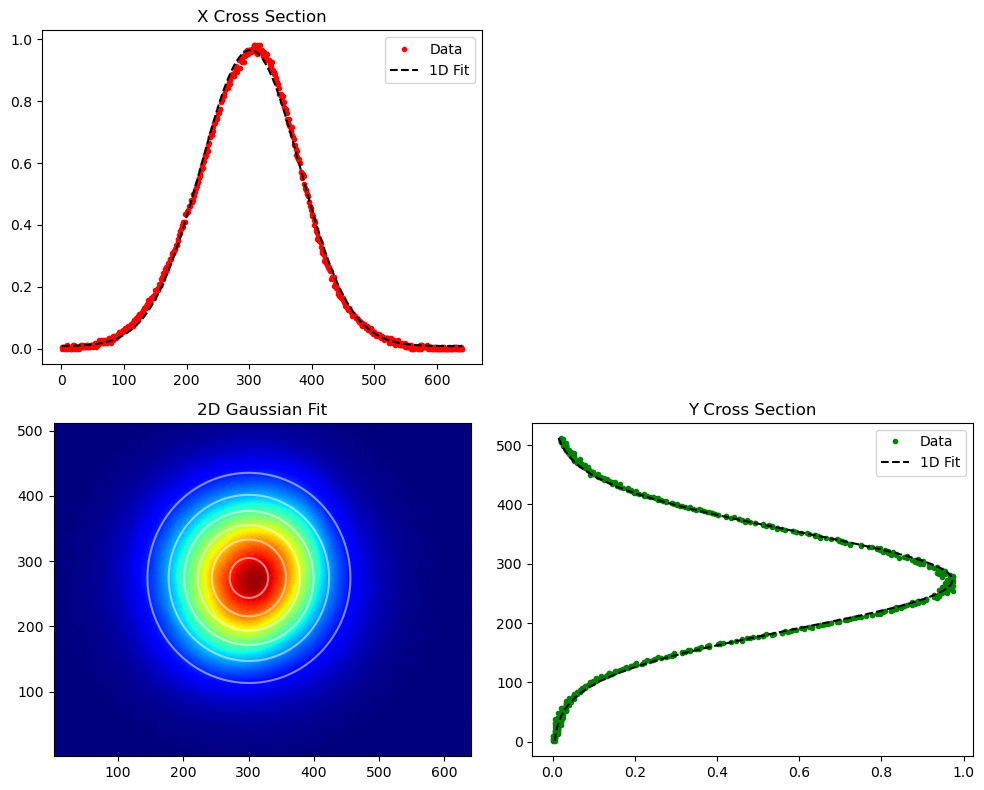

x           y
2D Fit       801.840209  830.500487
1D Fit       790.300931  824.218900
Radius (um)  801.840209  830.500487

In [5]:
scan = plt.imread(r"C:\Users\torre\Nextcloud\GQuEST\B102\Output Filter Cavity\Coresonance\locked on 775 - high 1550 power - no saturation.bmp").astype(float)
a=fit(scan)

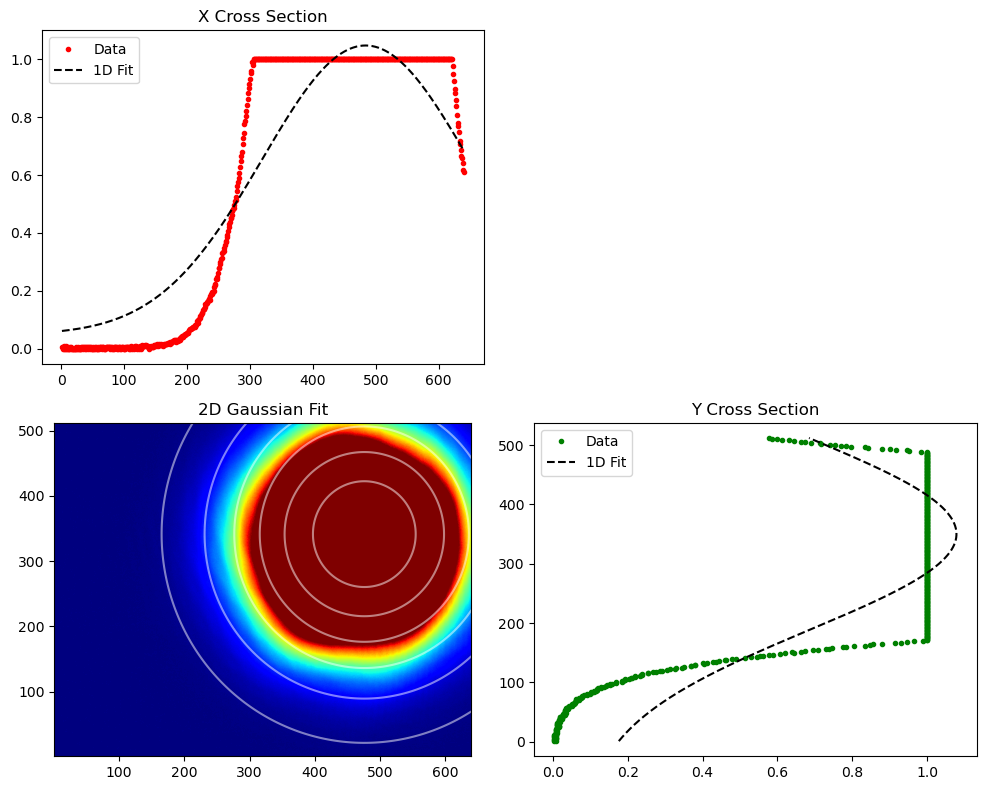

x            y
2D Fit       1523.236416  1568.484776
1D Fit       1643.708421  1617.326024
Radius (um)  1523.236416  1568.484776

In [6]:
scan = plt.imread(r"C:\Users\torre\Nextcloud\GQuEST\B102\Output Filter Cavity\Coresonance\locked on 775 - high 1550 power.bmp").astype(float)
a=fit(scan)

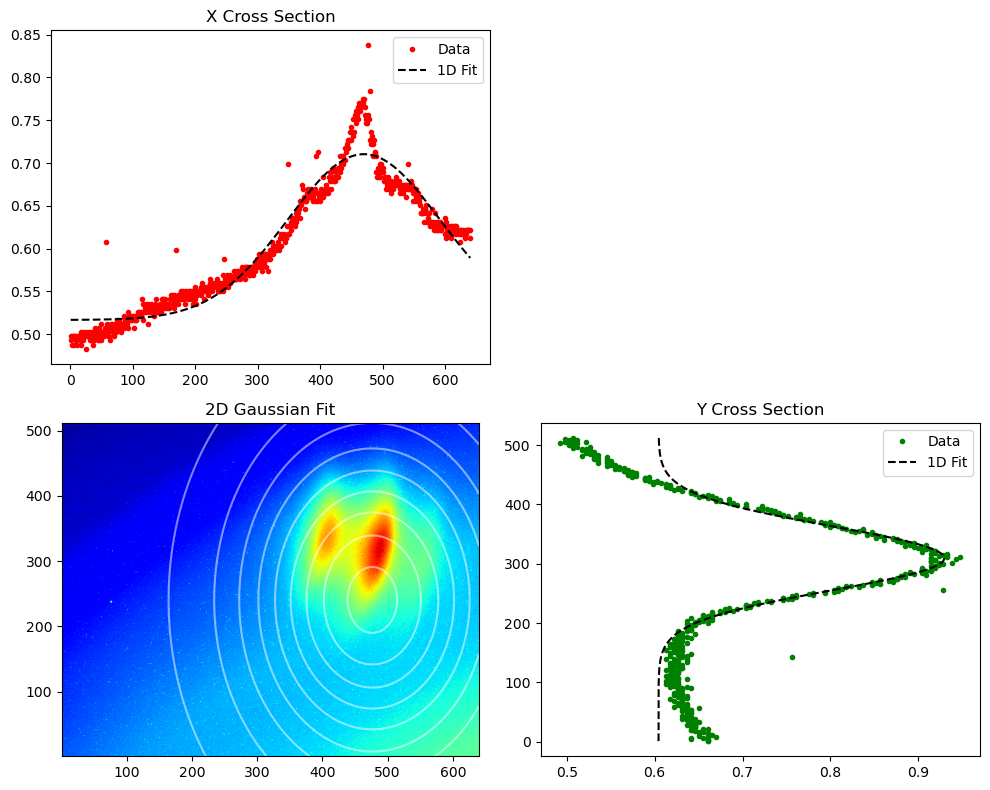

x            y
2D Fit       1271.424039  1690.628530
1D Fit       1213.560678   540.398291
Radius (um)  1271.424039  1690.628530

In [7]:
scan2 = plt.imread(r"C:\Users\torre\Nextcloud\GQuEST\B102\Output Filter Cavity\Coresonance\locked on 775 - low 1550 power.bmp").astype(float)
a2=fit(scan2)

240496.1560890735


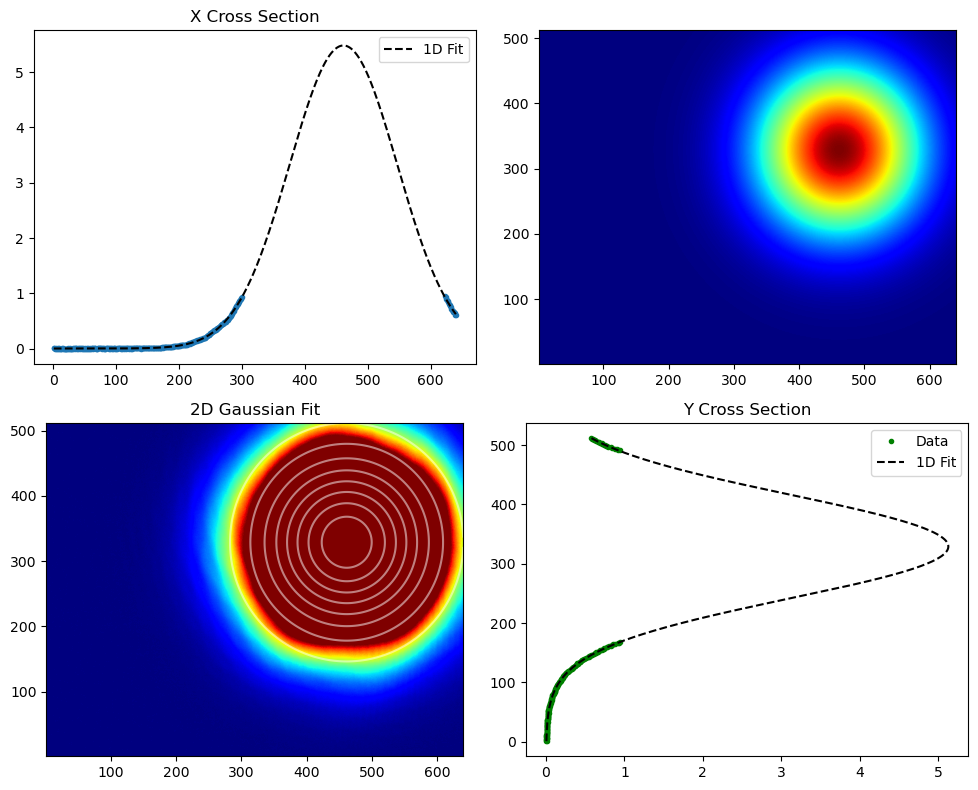

x            y
2D Fit       1523.236416  1568.484776
1D Fit        856.080035   874.464497
Radius (um)  1523.236416  1568.484776

In [8]:
scan1 = plt.imread(r"C:\Users\torre\Nextcloud\GQuEST\B102\Output Filter Cavity\Coresonance\locked on 775 - high 1550 power.bmp").astype(float)
a1=fit_saturated(scan)